In [1]:
import os, sys

# Change working directory to project root (two levels up from /src/training/)
os.chdir(os.path.abspath(os.path.join(os.getcwd(), '..', '..')))
sys.path.append(os.getcwd())

In [44]:
import numpy as np
import matplotlib.pyplot as plt
from src.core.config import MAXIMUM_MOVES, DETECTIVE_INITIAL_TICKETS, MRX_INITIAL_TICKETS, INITIAL_NUMBER_OF_2X_TICKETS
from src.core.transport import TransportType, Ticket
from src.core.board import Board

## Random games generation

In [3]:
board = Board(board_data_filePath="src/core/data/board.txt")

possible_initial_positions = []
with open("src/core/data/initial_positions.txt", 'r') as file:
    possible_initial_positions = [int(line.strip()) for line in file]

In [4]:
def get_detective_available_transport_types(detective_number: int, current_position: int, tickets):
    result = []
    available_transport_types = board.get_possible_transport_types(current_position)

    if (tickets[3*detective_number] > 0) and TransportType.TAXI in available_transport_types:
        result.append([TransportType.TAXI, tickets[3*detective_number]])

    if (tickets[3*detective_number+1] > 0) and TransportType.BUS in available_transport_types:
        result.append([TransportType.BUS, tickets[tickets[3*detective_number+1]]])

    if (tickets[3*detective_number+2] > 0) and TransportType.UNDERGROUND in available_transport_types:
        result.append([TransportType.UNDERGROUND, tickets[3*detective_number+2]])

    return np.array(result)

def generate_single_game(num_detectives: int, num_moves: int):
    winner = -1 # 1 = detective won; -1 = MrX won.
    positions = np.zeros((num_moves, num_detectives+1), dtype=int) # Columns are n detectives + Mrx
    # Columns are D1 Taxi, D1 Bus, D1 Underground, D2 Taxi, ..., Dn Underground, Mrx Black, Mrx 2x
    tickets = np.zeros((num_moves, 3*num_detectives+2), dtype=int) 

    # 1. Start game with random positions.
    random_positions = np.random.choice(possible_initial_positions, size=n + 1, replace=False)
    positions[0, :] = random_positions
    initial_tickets = [DETECTIVE_INITIAL_TICKETS[TransportType.TAXI], DETECTIVE_INITIAL_TICKETS[TransportType.BUS], DETECTIVE_INITIAL_TICKETS[TransportType.UNDERGROUND]] * num_detectives + [MRX_INITIAL_TICKETS[TransportType.BLACK], INITIAL_NUMBER_OF_2X_TICKETS]
    tickets[0, :] = np.array(initial_tickets)

    for m in range(num_moves - 1):
        tickets[m+1, :] = tickets[m, :]

        # 2. For each detective randomly pick any of possible ticket type and then get random possible next possition.
        for i in range(num_detectives):
            available_transport_types = get_detective_available_transport_types(i, positions[m, i], tickets[m, :])

            if len(available_transport_types) == 0 or np.sum(available_transport_types[:, 1]) == 0:
                break
            
            # Selecting tickets with probabilities higher for tickets that are more. This can be revisited to update
            # based on the results, if required.
            # probabilities = 100  * available_transport_types[:, 1] // np.sum(available_transport_types[:, 1])

            # Making sum of probabilities to 100 by adding remaining to the smallest. The sum will never be grater than 100 as we
            # are taking floor while dividing
            # if np.sum(probabilities) < 100:
            #     probabilities[np.argmin(probabilities)] += (100 - np.sum(probabilities))

            chosen_transport_type = np.random.choice(available_transport_types[:, 0]) # p=[i/100 for i in probabilities]

            possible_positions = board.get_possible_destinations(positions[m, i], chosen_transport_type, False)
            chosen_position = np.random.choice(possible_positions)

            # Update positions and tickets in the results
            positions[m+1, i] = chosen_position
            if chosen_transport_type == TransportType.TAXI:
                tickets[m+1, 3*i] -= 1
            elif chosen_transport_type == TransportType.BUS:
                tickets[m+1, 3*i + 1] -= 1
            elif chosen_transport_type == TransportType.UNDERGROUND:
                tickets[m+1, 3*i + 2] -= 1

        # 3. For MrX, additionally get probability of using 2X ticket.
        chosen_transport_type: TransportType
        available_transport_types = board.get_possible_transport_types(positions[m, -1])

        is_black_ticket_available: bool = tickets[m, -2] > 0
        should_use_black_ticket_as_mask: bool = False

        if is_black_ticket_available and TransportType.BLACK in available_transport_types:
            if len(available_transport_types) == 1 or np.random.choice([True, False]):
                chosen_transport_type = TransportType.BLACK
            else:
                chosen_transport_type = np.random.choice([t for t in available_transport_types if t != TransportType.BLACK])
        else:
            chosen_transport_type = np.random.choice(available_transport_types)
            if is_black_ticket_available:
                # To represent the case where black ticket is used as mask for actual transport.
                should_use_black_ticket_as_mask = np.random.choice([True, False], p=[0.4, 0.6])

        is_double_ticket_available: bool = tickets[m, -1] > 0
        # 10% because 2 tickets out of 24 moves.
        should_use_double_ticket = \
            np.random.choice([True, False], p=[0.1, 0.9]) \
            if is_double_ticket_available \
            else False

        possible_positions = board.get_possible_destinations(positions[m, -1], chosen_transport_type, should_use_double_ticket)
        chosen_position = np.random.choice(possible_positions)

        # Update positions and tickets in the resultschosen_transport_type 
        positions[m+1, -1] = chosen_position
        if chosen_transport_type == TransportType.BLACK or should_use_black_ticket_as_mask:
            tickets[m+1, -2] -= 1
        if should_use_double_ticket:
            tickets[m+1, -1] -= 1

        # 4. Check result
        if positions[m+1, -1] in positions[m+1, :-1]:
            winner = 1 # Detectives won
            break

    return winner, positions, tickets


In [47]:
def generate_forward_games(iterations, n=4, m=MAXIMUM_MOVES):
    result_winner = np.zeros(iterations, dtype=int) # 1 = detective won; -1 = MrX won.
    result_positions = np.zeros((iterations, m, n+1), dtype=int) # n detectives + Mrx
    result_tickets = np.zeros((iterations, m, 3*n+2), dtype=int) # 3 transport type for n detectives + Black, 2X for Mrx

    for i in range(iterations):
        g_winner, g_positions, g_tickets = generate_single_game(num_detectives=n, num_moves=m)
        result_winner[i] = g_winner
        result_positions[i, :, :] = g_positions
        result_tickets[i, :, :] = g_tickets

    # Analysis
    freq_result_winning_position = np.zeros(201)
    for mrx_pos in result_positions[result_winner==1][:, :, -1]:
        freq_result_winning_position[mrx_pos[int(np.nonzero(mrx_pos)[0][-1])]] += 1

    f = freq_result_winning_position / 200
    entropy = -1*np.sum(f[f!=0] * np.log(f[f!=0]))
    print(f"Results={np.sum(result_winner==1)}/{len(result_winner)}")
    print(f"Entropy={entropy}")
    print(f"Number of nodes with 2-digit winning games = {np.sum(freq_result_winning_position>9)}")
    print(f"Frequency of winning nodes = {print(freq_result_winning_position)}")

    plt.figure(figsize=(12, 8))
    plt.bar(np.arange(len(freq_result_winning_position)), freq_result_winning_position)
    plt.xlabel("Node")
    plt.ylabel("Frequency")

    plt.show()

Results=201/1000
Entropy=4.048007318583142
Number of nodes with 2-digit winning games = 2
[ 0.  0.  0.  0.  0.  1.  0.  1.  0.  0.  0.  0.  0.  4.  0.  7.  0.  0.
  0.  0.  1.  0.  3.  1.  1.  0.  0.  1.  0.  2.  0.  0.  0.  0.  0.  0.
  1.  1.  1.  2.  1.  3.  2.  0.  0.  0.  4.  0.  0.  0.  0.  1.  1.  0.
  1.  0.  0.  0.  1.  0.  0.  2.  0.  2.  0.  2.  0. 12.  4.  1.  0.  0.
  0.  0.  0.  0.  0.  1.  0.  3.  0.  0.  2.  0.  0.  0.  5.  4.  3.  5.
  0.  2.  2.  0.  0.  0.  1.  0.  0.  0.  2.  0.  1.  0.  0.  8.  0.  0.
  0.  0.  0.  3.  0.  1.  2.  1.  2.  1.  3.  0.  0.  0.  0.  1.  2.  0.
  1.  2.  0.  0.  0.  0.  0.  3.  1.  4.  0.  0.  0.  0.  8.  1.  5.  1.
  0.  0.  0.  0.  0.  0.  0.  1.  0.  9.  3.  0.  3.  4.  0. 10.  0.  1.
  0.  0.  0.  0.  3.  1.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.
  1.  0.  0.  2.  5.  8.  0.  1.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.
  1.  1.  0.]
Frequency of winning nodes = None


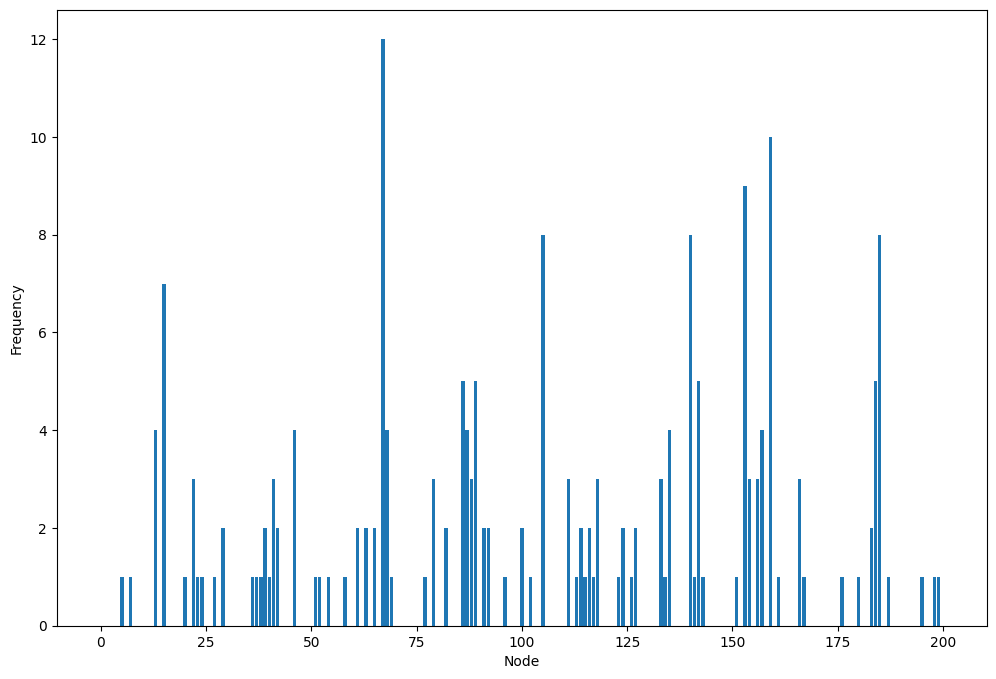

In [49]:
generate_forward_games(iterations=1000)

Results=497/2500
Entropy=8.257727110538838
Number of nodes with 2-digit winning games = 17
[ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  1.  0.  0. 16.  3. 16.  2.  0.
  0.  0.  0.  0.  5.  4.  0.  5.  3.  1.  5. 18.  0.  0.  0.  0.  2.  0.
  0.  2.  5.  1.  1. 10.  6.  0.  0.  0. 12.  1.  1.  0.  1.  5.  9.  0.
  1.  3.  0.  0.  4.  0.  0.  0.  0.  8.  0.  5.  2. 22.  3.  0.  1.  4.
  6.  0.  0.  0.  0.  1.  3. 10.  1.  0. 10.  0.  1.  0. 12.  6.  0. 13.
  0.  1.  0.  0.  2.  1.  0.  0.  2.  0.  3.  0.  5.  0.  0. 13.  0.  2.
  0.  1.  0.  6.  0.  1.  4.  5.  5.  2.  9.  0.  0.  0.  0.  2.  7.  0.
  2. 10.  0.  2.  0.  0.  0.  2.  0.  7.  0.  0.  0.  0. 23.  2.  6.  1.
  1.  0.  0.  0.  0.  0.  0.  1.  2. 15.  4.  1.  9. 11.  0. 14.  1.  6.
  1.  0.  0.  3.  1.  0.  2.  0.  2.  4.  1.  2.  0.  0.  1.  0.  0.  0.
  2.  0.  1.  2. 12.  9.  0.  2.  3.  0.  0.  1.  0.  0.  1.  0.  2.  0.
  0.  1.  1.]
Frequency of winning nodes = None


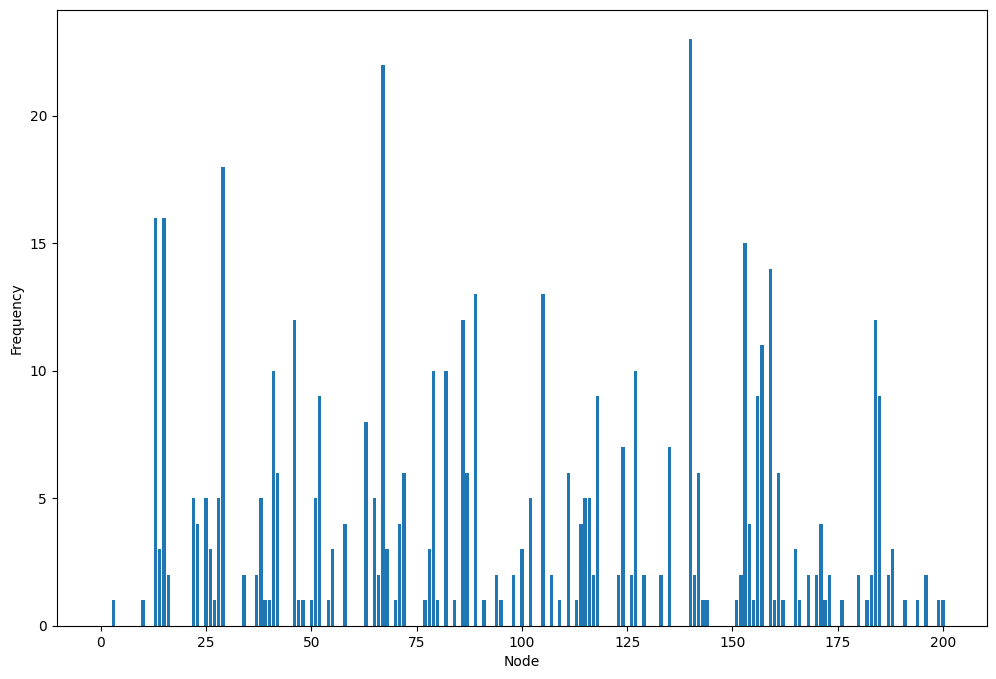

In [50]:
generate_forward_games(iterations=2500)

Results=488/2500
Entropy=8.243266176938638
Number of nodes with 2-digit winning games = 13
[ 0.  0.  0.  3.  0.  0.  0.  0.  0.  0.  0.  0.  0. 14.  2. 13.  2.  0.
  0.  0.  0.  0.  5.  7.  2.  1.  3.  3.  1. 13.  0.  0.  0.  1.  1.  2.
  1.  1.  4.  2.  1. 17.  7.  0.  0.  0.  8.  0.  0.  0.  1.  7.  9.  2.
  1.  5.  0.  0.  2.  0.  0.  0.  0.  5.  1.  3.  0. 20.  4.  2.  0.  2.
  6.  0.  0.  0.  0.  2.  1.  7.  0.  1.  6.  0.  1.  1.  9.  8.  2. 17.
  1.  2.  0.  1.  0.  0.  1.  0.  0.  0. 11.  0.  7.  2.  0. 15.  0.  4.
  0.  0.  0.  4.  0.  0.  1.  5.  5.  2.  6.  0.  0.  0.  0.  2.  2.  1.
  1.  9.  1.  2.  0.  1.  0.  5.  0.  5.  1.  0.  0.  0. 20.  1.  8.  1.
  1.  0.  0.  0.  0.  0.  1.  1.  0. 17.  2.  3.  6. 15.  2. 19.  1.  5.
  0.  1.  1.  2.  1.  2.  3.  0.  1.  3.  2.  4.  1.  0.  0.  0.  0.  0.
  2.  0.  1.  1.  4. 10.  0.  5.  1.  0.  0.  1.  0.  1.  0.  0.  0.  0.
  0.  2.  0.]
Frequency of winning nodes = None


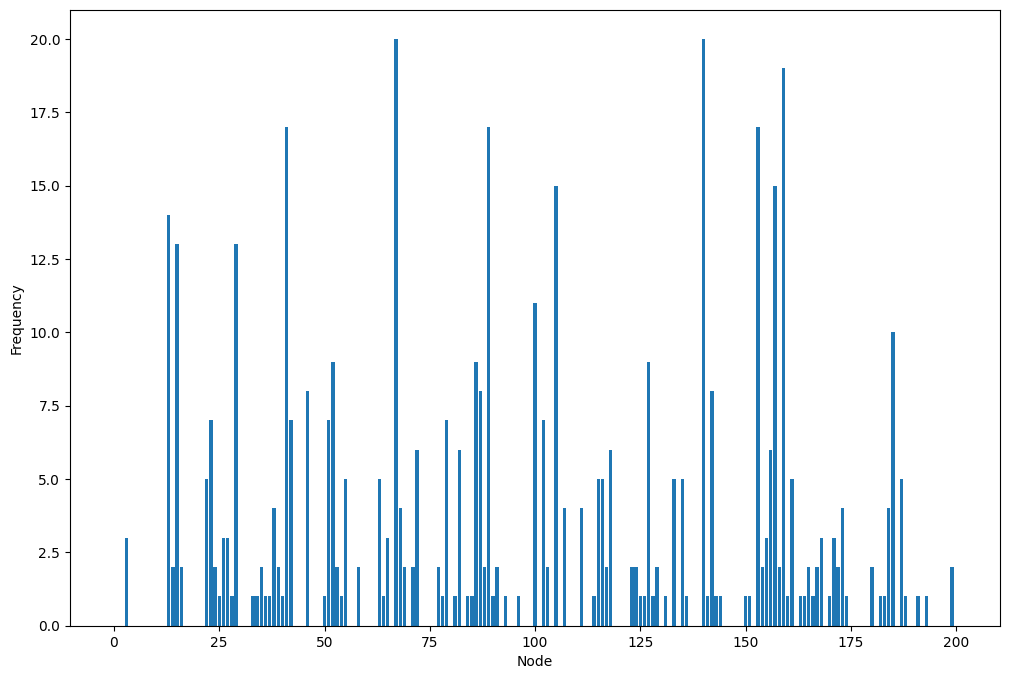

In [54]:
generate_forward_games(iterations=2500)

Results=510/2500
Entropy=8.475730925736455
Number of nodes with 2-digit winning games = 13
[ 0.  0.  0.  1.  1.  0.  0.  2.  0.  0.  0.  0.  0. 15.  5. 16.  3.  1.
  1.  0.  0.  0.  4.  4.  0.  2.  1.  0.  4. 10.  0.  0.  0.  0.  6.  3.
  2.  1.  1.  4.  2. 10.  8.  0.  0.  0.  9.  0.  0.  1.  1.  7.  7.  0.
  3.  3.  0.  0.  2.  0.  0.  1.  0.  1.  0.  4.  2. 26.  6.  0.  3.  1.
  7.  0.  2.  0.  0.  1.  2. 14.  0.  1.  6.  0.  0.  3.  6.  4.  2. 13.
  0.  3.  0.  0.  1.  0.  0.  0.  1.  0.  7.  0.  7.  3.  0. 14.  0.  4.
  0.  1.  0.  2.  0.  2.  3.  1. 10.  3.  6.  0.  0.  0.  0.  1.  4.  0.
  3.  9.  0.  1.  0.  1.  1.  3.  0.  1.  2.  0.  0.  1. 21.  0.  5.  0.
  0.  0.  1.  0.  0.  0.  0.  1.  0. 24.  4.  0.  9. 11.  0. 28.  3.  3.
  0.  5.  0.  2.  2.  0.  1.  0.  2.  3.  0.  1.  2.  0.  0.  0.  0.  0.
  2.  1.  0.  5.  8.  8.  0.  3.  2.  0.  0.  3.  0.  1.  1.  1.  2.  0.
  0.  4.  1.]
Frequency of winning nodes = None


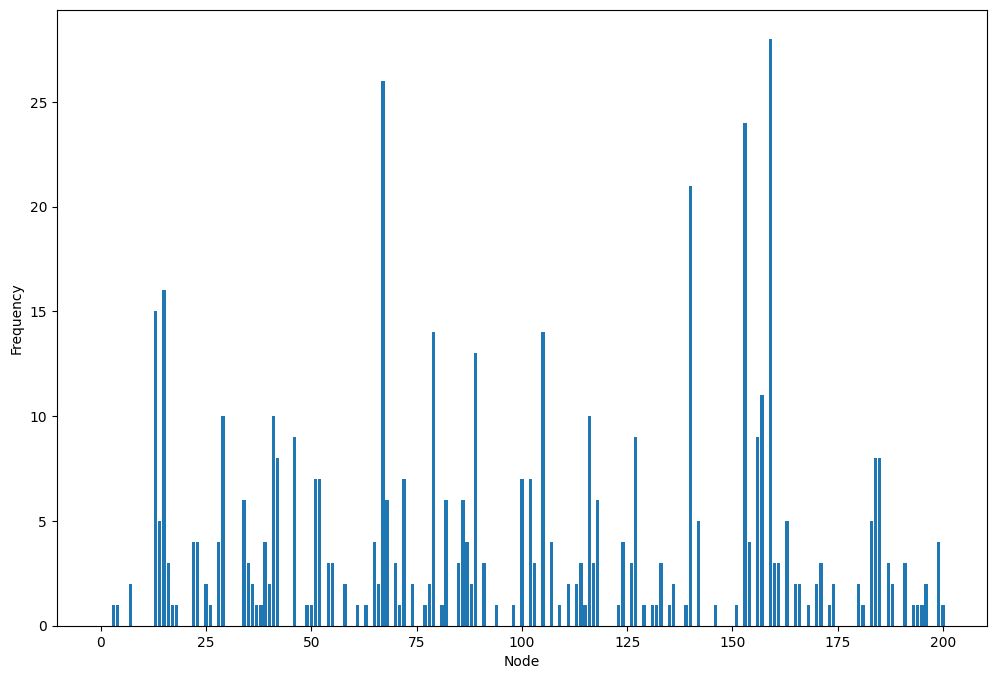

In [55]:
generate_forward_games(iterations=2500)

Results=1013/5000
Entropy=13.761708071099031
Number of nodes with 2-digit winning games = 36
[ 0.  0.  0.  3.  1.  0.  1.  1.  1.  0.  0.  1.  0. 29.  9. 37.  2.  0.
  0.  0.  0.  0. 14. 21.  1.  4.  2.  5.  9. 24.  1.  0.  0.  1.  5.  1.
  0.  2.  5.  2.  4. 24. 16.  0.  0.  0. 15.  0.  2.  2.  2.  3. 18.  2.
  7. 10.  1.  0.  3.  0.  0.  0.  1.  6.  0. 12.  2. 43. 12.  1.  2.  7.
  5.  0.  0.  0.  0.  4.  3. 21.  0.  1.  9.  0.  2.  2. 17. 14.  2. 29.
  1.  5.  0.  2.  1.  0.  1.  0.  3.  3.  3.  0. 12.  1.  2. 20.  1.  7.
  0.  1.  2. 16.  0.  1.  4. 14. 17.  6. 11.  1.  0.  0.  0.  4. 12.  0.
 11. 13.  6.  3.  0.  2.  0.  7.  1.  6.  1.  0.  2.  3. 44.  2. 18.  6.
  1.  0.  1.  0.  0.  0.  1.  2.  2. 41. 11.  2. 14. 22.  3. 44.  3. 11.
  0.  4.  0.  0.  6.  2.  1.  2.  1. 10.  0.  2.  0.  1.  0.  0.  1.  0.
  3.  2.  0.  3.  9. 23.  2.  5.  4.  0.  0.  1.  0.  1.  0.  0.  1.  1.
  3.  5.  0.]
Frequency of winning nodes = None


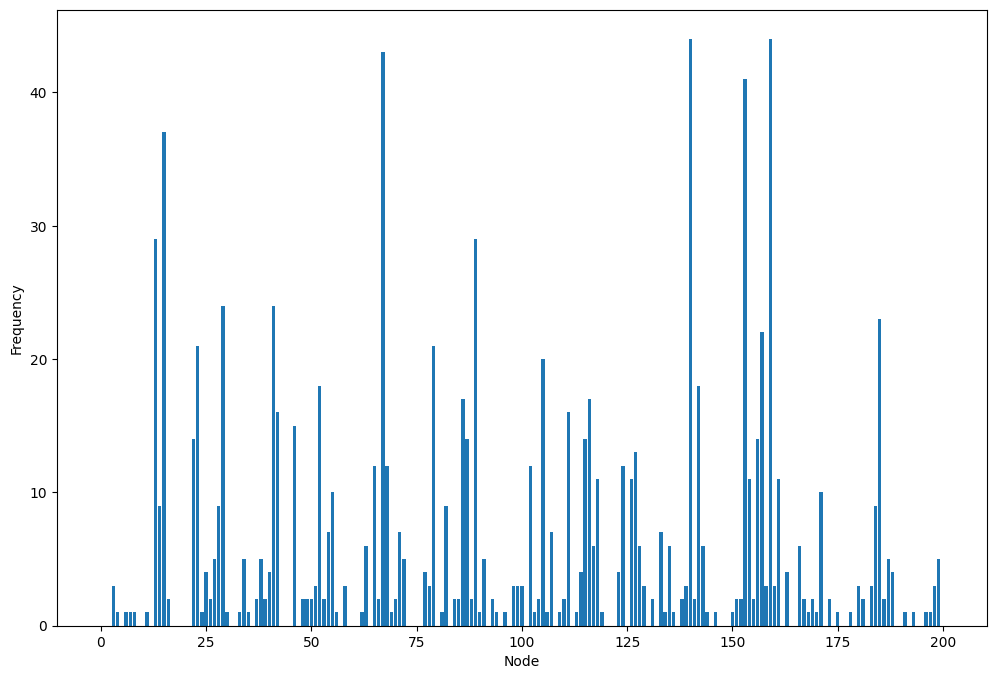

In [51]:
generate_forward_games(iterations=5000)

Results=2032/10000
Entropy=21.00426087423566
Number of nodes with 2-digit winning games = 54
[ 0.  3.  0.  6.  0.  0.  0.  4.  0.  0.  0.  1.  0. 52. 17. 55.  9.  4.
  0.  1.  2.  0. 23. 24.  4. 14.  8.  4.  8. 49.  1.  1.  0.  0.  9.  7.
  0.  4. 14.  7.  8. 50. 31.  0.  0.  1. 37.  2.  1.  1.  3. 20. 39.  6.
  7. 10.  1.  0.  4.  0.  0.  2.  2. 11.  4. 16.  4. 95. 19.  4. 10.  8.
 24.  0.  5.  0.  1.  6. 10. 35.  2.  2. 18.  0.  1.  1. 31. 32.  8. 75.
  8. 10.  0.  2.  5.  2.  0.  0.  5.  1. 23.  1. 24.  4.  1. 64.  1. 17.
  0.  2.  3. 23.  6.  2. 11. 16. 40.  1. 17.  2.  0.  0.  2.  7. 11.  8.
  5. 33.  7.  7.  2.  3.  3. 15.  6. 18.  2.  0.  0.  5. 82.  3. 30. 14.
  0.  0.  1.  0.  1.  1.  2.  3.  1. 81. 21. 10. 25. 42.  8. 89.  2. 10.
  1.  6.  0.  3.  4.  1.  5.  2.  4. 14.  2.  5.  2.  1.  0.  0.  0.  0.
  8.  6.  2.  8. 21. 51.  5.  9.  2.  0.  0.  3.  0.  1.  1.  1.  3.  3.
  3. 21.  5.]
Frequency of winning nodes = None


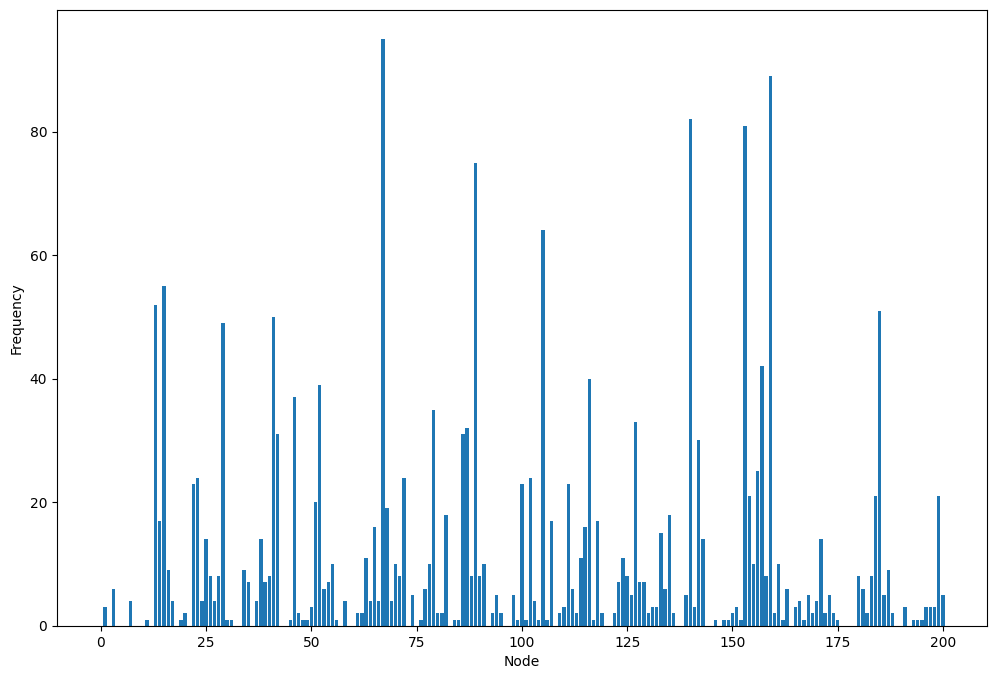

In [52]:
generate_forward_games(iterations=10000)

Results=4040/20000
Entropy=28.37869374915457
Number of nodes with 2-digit winning games = 86
[  0.   3.   0.  12.   1.   3.   0.   9.   0.   0.   1.   2.   0. 111.
  23. 107.  16.   4.   1.   0.   2.   0.  43.  63.   7.  20.  10.   8.
  22.  96.   1.   0.   0.   5.  16.  10.   9.  15.  15.  16.  23. 100.
  74.   0.   1.   0.  82.   3.   1.   5.   6.  31.  73.   7.  20.  29.
   3.   0.  13.   0.   1.   3.   4.  35.   2.  44.  14. 190.  46.   7.
  16.  25.  33.   0.  10.   2.   0.  16.  25.  60.   4.   4.  46.   1.
   2.   9.  57.  45.  10. 133.   7.  20.   0.   6.   5.   0.   0.   2.
   2.   7.  44.   6.  34.   3.   2. 120.   2.  36.   0.   4.   3.  53.
   4.   5.  24.  44.  68.  14.  63.   3.   0.   0.   3.   9.  45.   7.
  23.  60.   8.  13.   5.  12.   5.  35.  15.  22.   1.   1.   2.   7.
 139.  10.  53.  12.   5.   0.   2.   1.   0.   1.   2.   2.   5. 181.
  37.  11.  57.  87.  12. 165.  10.  31.   1.   6.   4.  12.   9.  14.
   6.   2.  11.  20.   6.  14.   1.   5.   0.   1.   0.

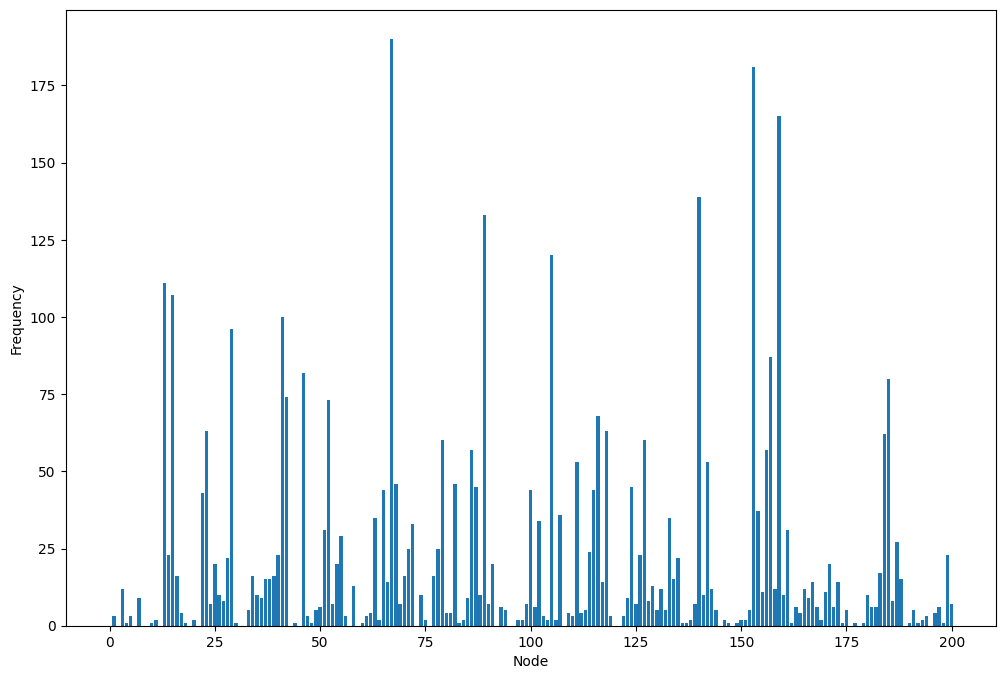

In [53]:
generate_forward_games(iterations=20000)